## Benchmark 6 revisit: linear models with structured bootstrap resampling
OK, one more time here. The data for November and December was just released. After adding it to the pile and submitting a naive control benchmark the new score-to-beat is ~1.4. Let's tune up and re-run our linear models to see where we are.
Two interesting considerations:
1. Submissions for 2023 need to be adjusted with the new 2023 census population numbers
2. We need to start thinking about the final submission where we will be scored on March, April and May 2023 starting from a forecast horizon of December 2022.

Point #1 we were able to handel without much trouble during the naive benchmark re-submission. The second is a bit more complicated but hopefully not too bad - it gives us a few different ways to think about scoring:

1. The public leaderboard up until final submission will be scored similarly to how is has been already, but now for January 2023, not November 2022 - so the only real difference is that we need to include the census data correction.
2. We also need to start predicting out to a forecast horizon of 5 to include March, April and May, also using our census data correction.
3. This gives us a few different ways to define the models score internally. First - SMAPE with a forecast horizon of one. This corresponds conceptually to the public leaderboard score. Second, SMAPE for forecast horizon +3 to +5 - this approximates the public private leaderboard score after the final submission. Finally, we could consider SMAPE for the whole forecast horizon of 5, this is probably the easiest and simplest way to evaluate model performance, but I think it will be an overestimate compared to the public leaderboard because it includes time proximal points which will likely have better scores.

Let's collect all three during our testing runs and make a decision about the best way to proceeded after.

1. [Abbreviations & definitions](#abbrevations_definitions)
2. [Results](#results)

<a name="abbreviations_definitions"></a>
### 1. Abbreviations & definitions
+ MBD: microbusiness density
+ MBC: microbusiness count
+ OLS: ordinary least squares
+ Model order: number of past timepoints used as input data for model training
+ Origin (forecast origin): last known point in the input data
+ Horizon (forecast horizon): number of future data points predicted by the model
+ SMAPE: Symmetric mean absolute percentage error

In [1]:
import sys
sys.path.append('..')
import config as conf
import functions.parallelization_functions as parallel_funcs

paths = conf.DataFilePaths()
params = conf.LinearModelsBootstrappingParameters()

import statistics
import multiprocessing as mp
import numpy as np
import pandas as pd
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statistics import NormalDist

<a name="results"></a>
### 2. Results

In [2]:
# Load and inspect results - each row is an individual datapoint from one of the conditions/samples
input_file = f'{paths.BOOTSTRAPPING_RESULTS_PATH}/{params.output_file_root_name}.parquet'
data_df = pd.read_parquet(input_file)
data_df.head()

,sample,model_type,model_order,total_SMAPE_values,public_SMAPE_value,private_SMAPE_values,detrended_total_SMAPE_values,detrended_public_SMAPE_value,detrended_private_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
0,0,control,3,"[0.03773583407618414, 0.018348616769632488, 0....",0.037736,"[0.018348616769632488, 0.0, 0.03636362245289294]","[0.05940591584354636, 0.11538456869822714, 0.1...",0.059406,"[0.11538456869822714, 0.09708733897634285, 0.1...","[2.56654, 2.56654, 2.56654, 2.56654, 2.56654]","[2.3288974999999996, 2.3288974999999996, 2.328...","[2.8680689, 2.8041825, 2.56654]","[0.19120479999999995, -0.0638863999999999, -0....","[2.471483, 2.6140685, 2.6140685, 2.56654, 2.66..."
1,0,OLS,3,"[0.010881576262110601, 0.13043826801741346, 0....",0.010882,"[0.1979547322737012, 0.2518538159032483, 0.364...","[0.1620877084052779, 0.3233258480103218, 0.439...",0.162088,"[0.439555392881314, 0.5511140194141823, 0.7264...","[2.4447348999999985, 2.293970449999998, 2.1432...","[2.1009179999999996, 1.8864943499999998, 1.672...","[2.8680689, 2.8041825, 2.56654]","[0.19120479999999995, -0.0638863999999999, -0....","[2.471483, 2.6140685, 2.6140685, 2.56654, 2.66..."
2,0,TS,3,"[0.012533069558242462, 0.1055906507781033, 0.1...",0.012533,"[0.17151702241147887, 0.22360446275615337, 0.3...","[0.17498410937231226, 0.3374065457270056, 0.45...",0.174984,"[0.4550848755966006, 0.568417930875384, 0.7455...","[2.5026536, 2.35188915, 2.2011247, 2.050360249...","[2.0738062999999998, 1.8593826499999997, 1.644...","[2.8680689, 2.8041825, 2.56654]","[0.19120479999999995, -0.0638863999999999, -0....","[2.471483, 2.6140685, 2.6140685, 2.56654, 2.66..."
3,0,Seigel,3,"[0.02279701367548902, 0.14308329792364954, 0.2...",0.022797,"[0.21141647041018424, 0.26624937952842714, 0.3...","[0.15569668955781849, 0.3163489254281243, 0.43...",0.155697,"[0.43186409231510536, 0.5425492049035616, 0.71...","[2.4157755499999998, 2.2650110999999997, 2.114...","[2.1144738499999995, 1.9000501999999995, 1.685...","[2.8680689, 2.8041825, 2.56654]","[0.19120479999999995, -0.0638863999999999, -0....","[2.471483, 2.6140685, 2.6140685, 2.56654, 2.66..."
4,0,Ridge,3,"[0.029406234579505995, 0.06694610824370059, 0....",0.029406,"[0.10884519797815147, 0.13422337242520352, 0.2...","[0.09654252395808337, 0.21766785546469772, 0.2...",0.096543,"[0.28700535126856175, 0.3430377465120986, 0.45...","[2.5452445333333333, 2.4447349, 2.344225266666...","[2.2438670999999997, 2.1009179999999996, 1.957...","[2.8680689, 2.8041825, 2.56654]","[0.19120479999999995, -0.0638863999999999, -0....","[2.471483, 2.6140685, 2.6140685, 2.56654, 2.66..."


In [3]:
# Calculate the final public SMAPE score for each sample in each condition
sample_smape_scores_df = data_df.groupby(['sample', 'model_type', 'model_order'])[['public_SMAPE_value', 'detrended_public_SMAPE_value']].mean().mul(100)

# Rename columns to reflect the change from SMAPE values for a single prediction to
# SMAPE scores within a sample
sample_smape_scores_df.rename(inplace=True, columns={'public_SMAPE_value': 'public_SMAPE_score', 'detrended_public_SMAPE_value': 'detrended_public_SMAPE_score'})

# Clean up index and inspect. Now each sample in all of the conditions is represented by a single row
# with two SMAPE scores calculated from all of the datapoints in that condition and sample. One from
# the fit and forecast on the raw data and the other from the fit and forecast on the difference
# detrended data
sample_smape_scores_df.reset_index(inplace=True, drop=False)
sample_smape_scores_df.head()

,sample,model_type,model_order,public_SMAPE_score,detrended_public_SMAPE_score
0,0,OLS,3,2.129815,5.479445
1,0,OLS,6,1.981907,3.771645
2,0,OLS,9,3.888462,0.847099
3,0,Ridge,3,1.832731,4.090837
4,0,Ridge,6,1.703462,3.626370


OK, let's take a look! Going to use a boxplot to look at the distribution of sample SMAPE scores across the different models and model orders. We also have fits to the raw and detrended data to look at. Keep in mind that the detrended fit was used to generate a raw MBD value for scoring purposes, so the underlying scale of the raw and detrended data panels are the same.

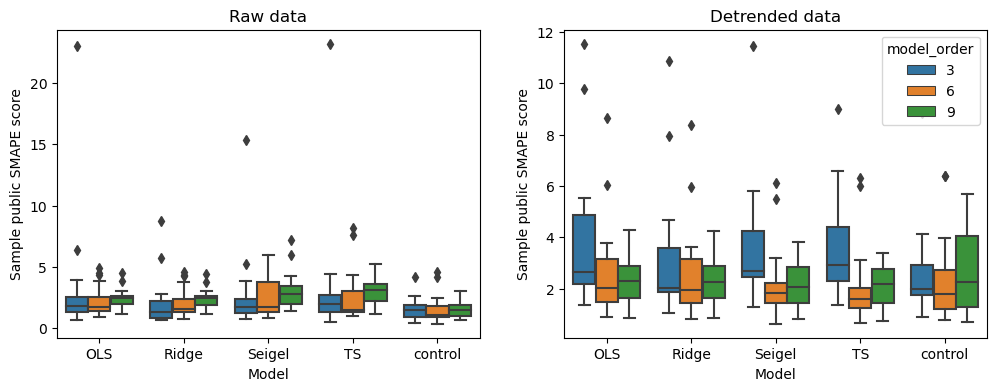

In [4]:
fig, ax = plt.subplots(1, 2,figsize=(12,4))

sns.boxplot(
    data=sample_smape_scores_df, 
    x='model_type',
    y='public_SMAPE_score',
    hue='model_order',
    ax=ax[0]
)

ax[0].set(
    xlabel='Model', 
    ylabel='Sample public SMAPE score', 
    title='Raw data'
)
        # Collect detrended model forecast
ax[0].get_legend().remove()

sns.boxplot(
    data=sample_smape_scores_df, 
    x='model_type',
    y='detrended_public_SMAPE_score',
    hue='model_order',
    ax=ax[1]
)

ax[1].set(
    xlabel='Model', 
    ylabel='Sample public SMAPE score', 
    title='Detrended data'
)

plt.show()

Now, let's compare another way by plotting individual SMAPE values for all the datapoints in control vs regression.


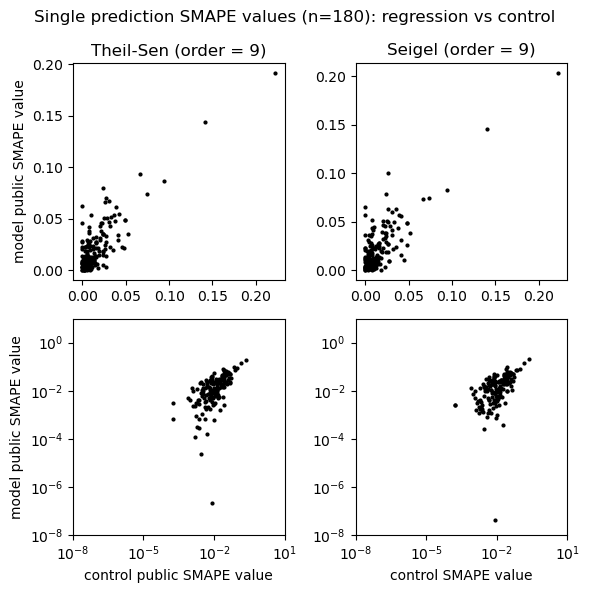

In [5]:
order = 9

fig, ax = plt.subplots(2, 2, figsize=(6,6))

ax[0,0].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == order)]['public_SMAPE_value'],
    data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == order)]['detrended_public_SMAPE_value'],
    color='black',
    s=4
)

ax[0,0].set_ylabel('model public SMAPE value')
ax[0,0].set_title(f'Theil-Sen (order = {order})')

ax[0,1].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == order)]['public_SMAPE_value'],
    data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == order)]['detrended_public_SMAPE_value'],
    color='black',
    s=4
)

ax[0,1].set_title(f'Seigel (order = {order})')

ax[1,0].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == order)]['public_SMAPE_value'],
    data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == order)]['detrended_public_SMAPE_value'],
    color='black',
    s=4
)

ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('control public SMAPE value')
ax[1,0].set_ylabel('model public SMAPE value')
ax[1,0].set_xlim([10**-8,10])
ax[1,0].set_ylim([10**-8,10])

ax[1,1].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == order)]['public_SMAPE_value'],
    data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == order)]['detrended_public_SMAPE_value'],
    color='black',
    s=4
)

ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('control SMAPE value')
ax[1,1].set_xlim([10**-8,10])
ax[1,1].set_ylim([10**-8,10])

n = len(data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == order)]['detrended_public_SMAPE_value'])
plt.suptitle(f'Single prediction SMAPE values (n={n}): regression vs control')
plt.tight_layout()

Let's take a closer look at our winner(s).

In [6]:
# Aggregate scores again, this time averaging all of the samples in each condition so we have one datapoint for each model and order
mean_sample_smape_score_df = sample_smape_scores_df.groupby(['model_type', 'model_order'])[['public_SMAPE_score', 'detrended_public_SMAPE_score']].mean()

# Rename columns to reflect new value
mean_sample_smape_score_df.rename(inplace=True, columns={'public_SMAPE_score': 'mean_public_SMAPE_score', 'detrended_public_SMAPE_score': 'mean_detrended_public_SMAPE_score'})

# Clean up and inspect
mean_sample_smape_score_df.reset_index(inplace=True, drop=False)
mean_sample_smape_score_df.head()

,model_type,model_order,mean_public_SMAPE_score,mean_detrended_public_SMAPE_score
0,OLS,3,3.228478,3.783781
1,OLS,6,2.241122,2.670994
2,OLS,9,2.438792,2.278110
3,Ridge,3,2.078475,3.099456
4,Ridge,6,2.123854,2.598273


In [7]:
# Get top 10 models by mean detrended SMAPE score
detrended_top_10 = mean_sample_smape_score_df.sort_values(by=['mean_detrended_public_SMAPE_score']).head(10)

# Get winner type and order
winning_model_type = detrended_top_10['model_type'].to_list()[0]
winning_model_order = detrended_top_10['model_order'].to_list()[0]

# Get raw data for winner
winner = data_df[(data_df['model_type'] == winning_model_type) & (data_df['model_order'] == winning_model_order)]

# Get raw data for sample matched control
control = data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == winning_model_order)]

# Inspect
control.head(3)

,sample,model_type,model_order,total_SMAPE_values,public_SMAPE_value,private_SMAPE_values,detrended_total_SMAPE_values,detrended_public_SMAPE_value,detrended_private_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
100,0,control,9,"[0.008163187134694452, 0.0, 0.0040898899045756...",0.008163,"[0.004089889904575662, 0.012219942466872765, 0...","[0.012121345163631756, 0.02028403052816112, 0....",0.012121,"[0.016194476494808027, 0.008064587803000069, 0...","[1.9760286, 1.9760286, 1.9760286, 1.9760286, 1...","[2.0165211000000003, 2.0165211000000003, 2.016...","[2.1465161, 2.1627774, 2.0975056, 1.9355361, 1...","[-0.03252290000000002, 0.016261300000000034, -...","[1.9922254, 1.9760286, 1.9841269, 2.000324, 1...."
105,0,control,9,"[0.0021193463095601187, 0.004938285464435248, ...",0.002119,"[0.0, 0.005673769624125674, 0.006385250509723014]","[0.008504568047144785, 0.011323446710890438, 0...",0.008505,"[0.00638525050972285, 0.000711487329616253, 1....","[2.7368095, 2.7368095, 2.7368095, 2.7368095, 2...","[2.7193899000000004, 2.7193899000000004, 2.719...","[2.5309868, 2.5174932, 2.5180969, 2.5722914, 2...","[-0.042408, -0.013493599999999883, 0.000603700...","[2.7426159, 2.7503581, 2.7368095, 2.7213254, 2..."
110,0,control,9,"[0.0, 0.01398599863445577, 0.02090594210773503...",0.000000,"[0.020905942107735036, 0.03460207959406629, 0....","[0.0, 0.01398599863445577, 0.02090594210773503...",0.000000,"[0.020905942107735036, 0.03460207959406629, 0....","[2.3521616, 2.3521616, 2.3521616, 2.3521616, 2...","[2.3521616, 2.3521616, 2.3521616, 2.3521616, 2...","[2.0977867, 2.0977867, 2.2030809, 2.3852906, 2...","[-0.016517799999999916, 0.0, 0.105294199999999...","[2.3521616, 2.3852906, 2.4018552, 2.4349842, 2..."


In [8]:
winner.head(3)

,sample,model_type,model_order,total_SMAPE_values,public_SMAPE_value,private_SMAPE_values,detrended_total_SMAPE_values,detrended_public_SMAPE_value,detrended_private_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
102,0,TS,9,"[0.09272821472801587, 0.09874636636228773, 0.1...",0.092728,"[0.11718186943645478, 0.13982794291007966, 0.1...","[0.00967731738578745, 0.022171984432862207, 0....",0.009677,"[0.022395640877272308, 0.018560897937844444, 0...","[1.8156754750000001, 1.7900836500000001, 1.764...","[2.0115985375000003, 2.020332225, 2.0290659125...","[2.1465161, 2.1627774, 2.0975056, 1.9355361, 1...","[-0.03252290000000002, 0.016261300000000034, -...","[1.9922254, 1.9760286, 1.9841269, 2.000324, 1...."
107,0,TS,9,"[0.055369822958438814, 0.06365777390372454, 0....",0.055370,"[0.0795676471158577, 0.0960820038434985, 0.107...","[0.004020338814278624, 0.006232059041265928, 0...",0.004020,"[0.000686938753961681, 0.005593308374716771, 0...","[2.898797942857143, 2.9311956314285714, 2.9635...","[2.7316117749999997, 2.7332709499999996, 2.734...","[2.5309868, 2.5174932, 2.5180969, 2.5722914, 2...","[-0.042408, -0.013493599999999883, 0.000603700...","[2.7426159, 2.7503581, 2.7368095, 2.7213254, 2..."
112,0,TS,9,"[0.06340931605804243, 0.06164202852071938, 0.0...",0.063409,"[0.06678599004918769, 0.06501489239959757, 0.0...","[0.0029473569380319446, 0.01752365292649905, 0...",0.002947,"[0.025034135385491135, 0.039320418651609346, 0...","[2.50619410625, 2.5370006075000004, 2.56780710...","[2.3452391416666662, 2.343854649999999, 2.3424...","[2.0977867, 2.0977867, 2.2030809, 2.3852906, 2...","[-0.016517799999999916, 0.0, 0.105294199999999...","[2.3521616, 2.3852906, 2.4018552, 2.4349842, 2..."


In [9]:
control_mbd_actual = []

for mbd in control['MBD_actual']:
    control_mbd_actual.extend(mbd)

control_mbd_predictions = []

for mbd in control['MBD_predictions']:
    control_mbd_predictions.extend(mbd)


winner_mbd_actual = []

for mbd in winner['MBD_actual']:
    winner_mbd_actual.extend(mbd)

winner_mbd_predictions = []

for mbd in winner['detrended_MBD_predictions']:
    winner_mbd_predictions.extend(mbd)

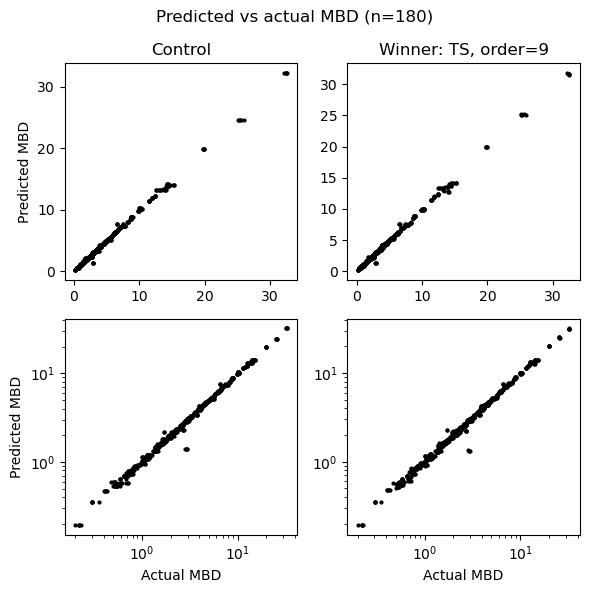

In [10]:
# Plot true vs predicted values
fig, ax = plt.subplots(2, 2, figsize=(6,6))

ax[0,0].scatter(
    control_mbd_actual,
    control_mbd_predictions,
    color='black',
    s=4
)

ax[0,0].set_ylabel('Predicted MBD')
ax[0,0].set_title('Control')

ax[0,1].scatter(
    winner_mbd_actual,
    winner_mbd_predictions,
    color='black',
    s=4
)

ax[0,1].set_title(f'Winner: {winning_model_type}, order={winning_model_order}')

ax[1,0].scatter(
    control_mbd_actual,
    control_mbd_predictions,
    color='black',
    s=4
)

ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')

ax[1,0].set_xlabel('Actual MBD')
ax[1,0].set_ylabel('Predicted MBD')

ax[1,1].scatter(
    winner_mbd_actual,
    winner_mbd_predictions,
    color='black',
    s=4
)

ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')

ax[1,1].set_xlabel('Actual MBD')

n = len(winner['MBD_actual'])
plt.suptitle(f'Predicted vs actual MBD (n={n})')
plt.tight_layout()

In [11]:
control_sample_smape_scores = sample_smape_scores_df[(sample_smape_scores_df['model_type'] == 'control') & (sample_smape_scores_df['model_order'] == winning_model_order)]
control_sample_smape_scores['public_SMAPE_score'].describe()

count    18.000000
mean      1.525431
std       0.616426
min       0.691600
25%       1.028932
50%       1.472844
75%       1.863939
max       3.076279
Name: public_SMAPE_score, dtype: float64

In [12]:
winner_sample_smape_scores = sample_smape_scores_df[(sample_smape_scores_df['model_type'] == winning_model_type) & (sample_smape_scores_df['model_order'] == winning_model_order)]
winner_sample_smape_scores['detrended_public_SMAPE_score'].describe()

count    18.000000
mean      2.078466
std       0.825779
min       0.729526
25%       1.432221
50%       2.182619
75%       2.758540
max       3.374183
Name: detrended_public_SMAPE_score, dtype: float64

In [13]:
t_test = stats.ttest_ind(winner_sample_smape_scores['detrended_public_SMAPE_score'], control_sample_smape_scores['public_SMAPE_score'])
print(f't-test p-value (H0: control mean = regression mean): {t_test[1]:.3e}')

t-test p-value (H0: control mean = regression mean): 2.920e-02


In [14]:

cm = sms.CompareMeans(sms.DescrStatsW(winner_sample_smape_scores['detrended_public_SMAPE_score']), sms.DescrStatsW(control_sample_smape_scores['public_SMAPE_score']))
ci = cm.tconfint_diff(usevar='unequal')
print(f'95% C.I. around difference in means: {ci[0]:.4f}, {ci[1]:.3f}')

95% C.I. around difference in means: 0.0580, 1.048


OK, unfortunately - this is more like the answer I think we should be getting. The winning model performs worse than the control on average, but not by much.  The control and winning distributions are definitely different. The difference, though small, is highly statistically significant because of the large sample sizes involved.

Let's check the probabilities of the observed leaderboard results before we move on to try and improve the result.

In [15]:
smape_mean = statistics.mean(winner_sample_smape_scores['detrended_public_SMAPE_score'])
smape_std = statistics.pstdev(winner_sample_smape_scores['detrended_public_SMAPE_score'])

print(f'Winner mean: {smape_mean:.3f}')
print(f'Winner standard deviation: {smape_std:.4f}')
print()

leaderboard_score_probability = NormalDist(mu=smape_mean, sigma=smape_std).cdf(1.4631)
print(f'Probability of model SMAPE <= 1.4631: {leaderboard_score_probability:.3f}')
print(f'Probability of model SMAPE > 1.4631: {1 - leaderboard_score_probability:.3f}')

Winner mean: 2.078
Winner standard deviation: 0.8025

Probability of model SMAPE <= 1.4631: 0.222
Probability of model SMAPE > 1.4631: 0.778


In [16]:
smape_mean = statistics.mean(control_sample_smape_scores['public_SMAPE_score'])
smape_std = statistics.pstdev(control_sample_smape_scores['public_SMAPE_score'])

print(f'Control mean: {smape_mean:.3f}')
print(f'Control standard deviation: {smape_std:.4f}')
print()

leaderboard_score_probability = NormalDist(mu=smape_mean, sigma=smape_std).cdf(1.4631)
print(f'Probability of control SMAPE <= 1.4631: {leaderboard_score_probability:.3f}')
print(f'Probability of control SMAPE > 1.4631: {1 - leaderboard_score_probability:.3f}')

Control mean: 1.525
Control standard deviation: 0.5991

Probability of control SMAPE <= 1.4631: 0.459
Probability of control SMAPE > 1.4631: 0.541


Ok, this looks pretty good - the observed public leaderboard score for the control is pretty much right in the middle of our sampling distribution. Using the observed leaderboard score as a cutoff on our best model's sampling distributions says we will 'win' in about 2 of 10 random samples.

This all looks pretty good, problem is, we are still loosing. On the bright side - we now can get a much better handle on the expected leaderboard results looking at our internal bootstrapping benchmark.

On additional interesting consideration here - the above analysis is derived from the +1 forecast only. In keeping with 'eyes-on-the-prize', the actual goal here is to predict +3 to +5. The regression models may actually do better in that scenario in some cases. If the MBD is going somewhere, the regression lines may capture is better than simply carrying a static value forward for 5 months. Let's take a quick look and see how it works out in our bootstrapping experiments.

In [17]:
# Get the smape scores for each three-point private prediction
private_smape_scores = []
detrended_private_smape_scores = []

for i, row in data_df.iterrows():

    private_smape_score = sum(row['private_SMAPE_values']) * (100/len(row['private_SMAPE_values']))
    detrended_private_smape_score = sum(row['detrended_private_SMAPE_values']) * (100/len(row['detrended_private_SMAPE_values']))

    private_smape_scores.append(private_smape_score)
    detrended_private_smape_scores.append(detrended_private_smape_score)

# Add as new columns in main data df
data_df['private_SMAPE_scores'] = private_smape_scores
data_df['detrended_private_SMAPE_scores'] = detrended_private_smape_scores

# Calculate the final private SMAPE score for each sample in each condition
sample_smape_scores_df = data_df.groupby(['sample', 'model_type', 'model_order'])[['private_SMAPE_scores', 'detrended_private_SMAPE_scores']].mean()

# Rename columns to reflect the change from SMAPE values for a single prediction to
# SMAPE scores within a sample
sample_smape_scores_df.rename(inplace=True, columns={'private_SMAPE_scores': 'private_SMAPE_score', 'detrended_private_SMAPE_scores': 'detrended_private_SMAPE_score'})

# Clean up index and inspect. Now each sample in all of the conditions is represented by a single row
# with two SMAPE scores calculated from all of the datapoints in that condition and sample. One from
# the fit and forecast on the raw data and the other from the fit and forecast on the difference
# detrended data
sample_smape_scores_df.reset_index(inplace=True, drop=False)
sample_smape_scores_df.head()

,sample,model_type,model_order,private_SMAPE_score,detrended_private_SMAPE_score
0,0,OLS,3,11.130977,16.182087
1,0,OLS,6,7.538055,5.782418
2,0,OLS,9,7.097520,1.875963
3,0,Ridge,3,8.019786,12.287136
4,0,Ridge,6,6.756906,5.526515


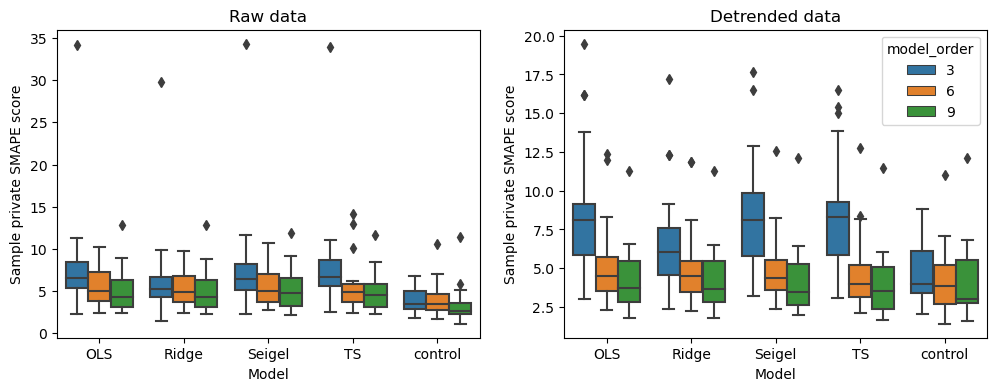

In [18]:
fig, ax = plt.subplots(1, 2,figsize=(12,4))

sns.boxplot(
    data=sample_smape_scores_df, 
    x='model_type',
    y='private_SMAPE_score',
    hue='model_order',
    ax=ax[0]
)

ax[0].set(
    xlabel='Model', 
    ylabel='Sample private SMAPE score', 
    title='Raw data'
)
        # Collect detrended model forecast
ax[0].get_legend().remove()

sns.boxplot(
    data=sample_smape_scores_df, 
    x='model_type',
    y='detrended_private_SMAPE_score',
    hue='model_order',
    ax=ax[1]
)

ax[1].set(
    xlabel='Model', 
    ylabel='Sample private SMAPE score', 
    title='Detrended data'
)

plt.show()

OK, let's get the winners again...

In [19]:
# Aggregate scores again, this time averaging all of the samples in each condition so we have one datapoint for each model and order
mean_sample_smape_score_df = sample_smape_scores_df.groupby(['model_type', 'model_order'])[['private_SMAPE_score', 'detrended_private_SMAPE_score']].mean()

# Rename columns to reflect new value
mean_sample_smape_score_df.rename(inplace=True, columns={'private_SMAPE_score': 'mean_private_SMAPE_score', 'detrended_private_SMAPE_score': 'mean_detrended_private_SMAPE_score'})

# Clean up and inspect
mean_sample_smape_score_df.reset_index(inplace=True, drop=False)
mean_sample_smape_score_df.head()

,model_type,model_order,mean_private_SMAPE_score,mean_detrended_private_SMAPE_score
0,OLS,3,8.289282,8.932061
1,OLS,6,5.692031,5.471647
2,OLS,9,5.044287,4.382995
3,Ridge,3,6.614730,7.021390
4,Ridge,6,5.458157,5.352175


In [20]:
# Get top 10 models by mean detrended SMAPE score
detrended_top_10 = mean_sample_smape_score_df.sort_values(by=['mean_detrended_private_SMAPE_score']).head(10)

# Get winner type and order
winning_model_type = detrended_top_10['model_type'].to_list()[0]
winning_model_order = detrended_top_10['model_order'].to_list()[0]

# Get raw data for winner
winner = data_df[(data_df['model_type'] == winning_model_type) & (data_df['model_order'] == winning_model_order)]

# Get raw data for sample matched control
control = data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == winning_model_order)]

# Inspect
control.head(3)

,sample,model_type,model_order,total_SMAPE_values,public_SMAPE_value,private_SMAPE_values,detrended_total_SMAPE_values,detrended_public_SMAPE_value,detrended_private_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual,private_SMAPE_scores,detrended_private_SMAPE_scores
100,0,control,9,"[0.008163187134694452, 0.0, 0.0040898899045756...",0.008163,"[0.004089889904575662, 0.012219942466872765, 0...","[0.012121345163631756, 0.02028403052816112, 0....",0.012121,"[0.016194476494808027, 0.008064587803000069, 0...","[1.9760286, 1.9760286, 1.9760286, 1.9760286, 1...","[2.0165211000000003, 2.0165211000000003, 2.016...","[2.1465161, 2.1627774, 2.0975056, 1.9355361, 1...","[-0.03252290000000002, 0.016261300000000034, -...","[1.9922254, 1.9760286, 1.9841269, 2.000324, 1....",0.680554,1.621646
105,0,control,9,"[0.0021193463095601187, 0.004938285464435248, ...",0.002119,"[0.0, 0.005673769624125674, 0.006385250509723014]","[0.008504568047144785, 0.011323446710890438, 0...",0.008505,"[0.00638525050972285, 0.000711487329616253, 1....","[2.7368095, 2.7368095, 2.7368095, 2.7368095, 2...","[2.7193899000000004, 2.7193899000000004, 2.719...","[2.5309868, 2.5174932, 2.5180969, 2.5722914, 2...","[-0.042408, -0.013493599999999883, 0.000603700...","[2.7426159, 2.7503581, 2.7368095, 2.7213254, 2...",0.401967,0.236558
110,0,control,9,"[0.0, 0.01398599863445577, 0.02090594210773503...",0.000000,"[0.020905942107735036, 0.03460207959406629, 0....","[0.0, 0.01398599863445577, 0.02090594210773503...",0.000000,"[0.020905942107735036, 0.03460207959406629, 0....","[2.3521616, 2.3521616, 2.3521616, 2.3521616, 2...","[2.3521616, 2.3521616, 2.3521616, 2.3521616, 2...","[2.0977867, 2.0977867, 2.2030809, 2.3852906, 2...","[-0.016517799999999916, 0.0, 0.105294199999999...","[2.3521616, 2.3852906, 2.4018552, 2.4349842, 2...",3.453933,3.453933


In [21]:
control_sample_smape_scores = sample_smape_scores_df[(sample_smape_scores_df['model_type'] == 'control') & (sample_smape_scores_df['model_order'] == winning_model_order)]
control_sample_smape_scores['private_SMAPE_score'].describe()

count    18.000000
mean      3.421032
std       2.336876
min       1.131639
25%       2.311462
50%       2.688744
75%       3.538356
max      11.397061
Name: private_SMAPE_score, dtype: float64

In [22]:
winner_sample_smape_scores = sample_smape_scores_df[(sample_smape_scores_df['model_type'] == winning_model_type) & (sample_smape_scores_df['model_order'] == winning_model_order)]
winner_sample_smape_scores['detrended_private_SMAPE_score'].describe()

count    18.000000
mean      4.011177
std       2.337227
min       1.631080
25%       2.374651
50%       3.518633
75%       5.083355
max      11.475446
Name: detrended_private_SMAPE_score, dtype: float64

In [23]:
t_test = stats.ttest_ind(winner_sample_smape_scores['detrended_private_SMAPE_score'], control_sample_smape_scores['private_SMAPE_score'])
print(f't-test p-value (H0: control mean = regression mean): {t_test[1]:.3e}')

t-test p-value (H0: control mean = regression mean): 4.539e-01


In [24]:

cm = sms.CompareMeans(sms.DescrStatsW(winner_sample_smape_scores['detrended_private_SMAPE_score']), sms.DescrStatsW(control_sample_smape_scores['private_SMAPE_score']))
ci = cm.tconfint_diff(usevar='unequal')
print(f'95% C.I. around difference in means: {ci[0]:.4f}, {ci[1]:.3f}')

95% C.I. around difference in means: -0.9930, 2.173


Ok, so not the result we were hoping for - means are not convincingly different. If anything the best regression model does worse than the carry forward control. Not completely unsurprising, but it was worth checking.